In [58]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [59]:
query =\
'''
SELECT DISTINCT *
FROM (
  SELECT DISTINCT
    phone_number AS user_id,
    main_funding_bank,
    surrounding_area_v2,
    est_daily_customer,
    -- offline_acquisition_flag,
    -- referral_acquisition_flag
  FROM `ledger-fcc1e.temp_rachel.merchant_profiling_data_for_mse_prioritization_v2`
)
LEFT JOIN (
  SELECT
    user_id,
    acquisition_channel,
    user_segment_bucket
  FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
) USING (user_id)
'''
raw = client.query(query).result().to_dataframe()
raw.to_pickle('data/raw_data.pkl')
raw = pd.read_pickle('data/raw_data.pkl')

In [60]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              8032 non-null   object
 1   main_funding_bank    6171 non-null   object
 2   surrounding_area_v2  8032 non-null   object
 3   est_daily_customer   5992 non-null   object
 4   acquisition_channel  7779 non-null   object
 5   user_segment_bucket  7779 non-null   object
dtypes: object(6)
memory usage: 376.6+ KB


In [61]:
df =\
(
    raw
    .assign(
        # offline_acquisition_flag = lambda x: x.offline_acquisition_flag.fillna(0).astype(bool),
        # referral_acquisition_flag = lambda x: x.referral_acquisition_flag.fillna(0).astype(bool)
        est_daily_customer = lambda x: pd.to_numeric(x.est_daily_customer)
    )
)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              8032 non-null   object 
 1   main_funding_bank    6171 non-null   object 
 2   surrounding_area_v2  8032 non-null   object 
 3   est_daily_customer   5992 non-null   float64
 4   acquisition_channel  7779 non-null   object 
 5   user_segment_bucket  7779 non-null   object 
dtypes: float64(1), object(5)
memory usage: 376.6+ KB


In [63]:
# df =\
# (
#     raw
#     .assign(
#         # acquisition_channel = lambda x: x.acquisition_channel.str.replace(' Acquisition',''),
#         kyc_tier = lambda x: x.kyc_tier.replace('NON-KYC','NONKYC').fillna('NONKYC'),
#         loyalty_tier = lambda x: x.loyalty_tier.fillna('Bronze'),
#         impressions_flag = lambda x: x.impressions_flag.astype(bool),
#         clicks_flag = lambda x: x.clicks_flag.astype(bool),
#     )
# )

# tpv_col = df.filter(regex='TPV|tpv').columns
# for i in tpv_col:
#     df[i] = pd.to_numeric(df[i])

# # normalize the numeric columns
# num_col = [col for col in df.select_dtypes(include=['float', 'int']).columns if '_flag' not in col]
# num_col = [col for col in df[num_col].columns if 'age' not in col]
# for i in num_col:
#     df[i] = df[i].fillna(0).apply(np.log1p)

# # turn object columns to dummy
# # df = pd.get_dummies(data=df, columns=['acquisition_channel', 'kyc_tier', 'loyalty_tier'], prefix=['pm_acq', 'pm_kyc', 'pm_lyl'], dtype=bool)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              8032 non-null   object 
 1   main_funding_bank    6171 non-null   object 
 2   surrounding_area_v2  8032 non-null   object 
 3   est_daily_customer   5992 non-null   float64
 4   acquisition_channel  7779 non-null   object 
 5   user_segment_bucket  7779 non-null   object 
dtypes: float64(1), object(5)
memory usage: 376.6+ KB


In [65]:
s = setup(
    df, 
    normalize=True, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(8032, 6)"
2,Transformed data shape,"(8032, 64)"
3,Ignore features,1
4,Numeric features,1
5,Categorical features,4
6,Rows with missing values,27.4%
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [66]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2737,212.7512,1.9736,0,0,0


In [67]:
plot_model(kmeans, 'cluster')

In [68]:
plot_model(kmeans, 'tsne')

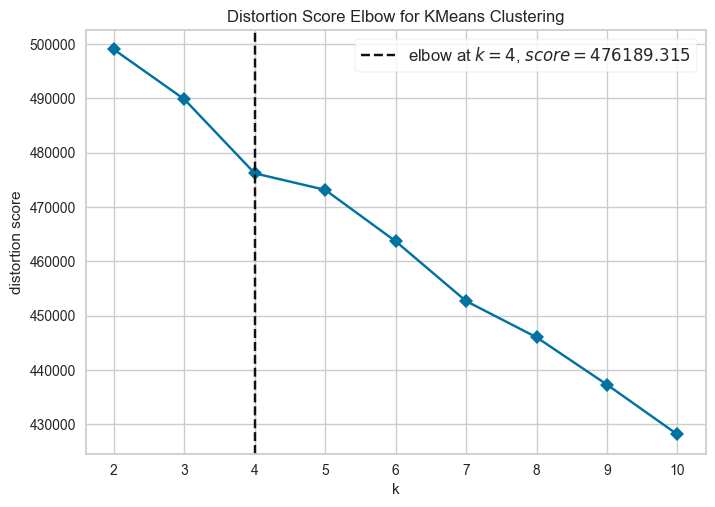

In [69]:
plot_model(kmeans, 'elbow')